## Race Predictions ##
### An exploration of data forcasting techniques so I don't forgot how data works in python ###

In [2]:
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

#### Load Data ####

For the data, I will be using the  'jolpi.ca F1 API' which can be found [here](https://api.jolpi.ca/ergast/).

At first I played around with the idea of loading and structuing all the data myself, although this was far less performant and would require the split into testing and training data manually,
So instead I will be using Pandas.

For now, I have each race in a seperate DF but later I will combine them into a single dataframe with a race ID column for actual modelling. But this looks nicer for data visualisation for now

In [3]:
# Output data in pandas dataframe
base_url = "http://api.jolpi.ca/ergast/f1/2024/results"
qualifying_url = "https://api.jolpi.ca/ergast/f1/2024/qualifying"
limit = 100
offset = 0

response = requests.get(f"{base_url}?limit={1}&offset={offset}").json()
total_results = int(response["MRData"]["total"])
race_dataframes = {}

while offset < total_results:
    response = requests.get(f"{base_url}?limit={limit}&offset={offset}").json()
    results = response["MRData"]["RaceTable"]["Races"]

    for race in results:
        race_name = race["raceName"] 
        if race_name not in race_dataframes:
            race_dataframes[race_name] = []

        for res in race["Results"]:
            race_dataframes[race_name].append({
                "DriverCode": res["Driver"]["code"],
                "ConstructorId": res["Constructor"]["constructorId"],
                "StartingPosition": int(res["grid"]),
                "RaceResult": int(res["position"]),
                "PositionsGained": int(res["grid"]) - int(res["position"]),
            })
    offset += limit

def lap_time_to_ms(lap_time):
    if not lap_time:
        return 0
    minutes, seconds = lap_time.split(":")
    total_ms = int(minutes) * 60 * 1000 + int(float(seconds) * 1000)
    return total_ms

offset = 0
response = requests.get(f"{qualifying_url}?limit={1}&offset={offset}").json()
total_results = int(response["MRData"]["total"])

while offset < total_results:
    response = requests.get(f"{qualifying_url}?limit={limit}&offset={offset}").json()
    results = response["MRData"]["RaceTable"]["Races"]

    for race in results:
        race_name = race["raceName"]
        for entry in race_dataframes[race_name]:
            driver = entry["DriverCode"]

            match = next( (result for result in race["QualifyingResults"] if result["Driver"]["code"] == driver), None )
            if match:
                entry["Q1TimeMS"] = lap_time_to_ms(match.get("Q1"))
                q2_time = lap_time_to_ms(match.get("Q2"))
                entry["Q2TimeMs"] = q2_time
                entry["Q2Progress"] = 1 if q2_time else 0
                q3_time = lap_time_to_ms(match.get("Q3"))
                entry["Q3TimeMs"] = q3_time
                entry["Q3Progress"] = 1 if q3_time else 0
    offset += limit

for race_name in race_dataframes:
    race_dataframes[race_name] = pd.DataFrame(race_dataframes[race_name])



print("Results for Bharain:")
print(race_dataframes["Bahrain Grand Prix"])


Results for Bharain:
   DriverCode ConstructorId  StartingPosition  RaceResult  PositionsGained  \
0         VER      red_bull                 1           1                0   
1         PER      red_bull                 5           2                3   
2         SAI       ferrari                 4           3                1   
3         LEC       ferrari                 2           4               -2   
4         RUS      mercedes                 3           5               -2   
5         NOR       mclaren                 7           6                1   
6         HAM      mercedes                 9           7                2   
7         PIA       mclaren                 8           8                0   
8         ALO  aston_martin                 6           9               -3   
9         STR  aston_martin                12          10                2   
10        ZHO        sauber                17          11                6   
11        MAG          haas                

#### Basic Data Visualisation ####

Just to get a bit of a look at the data before we try some forcasting

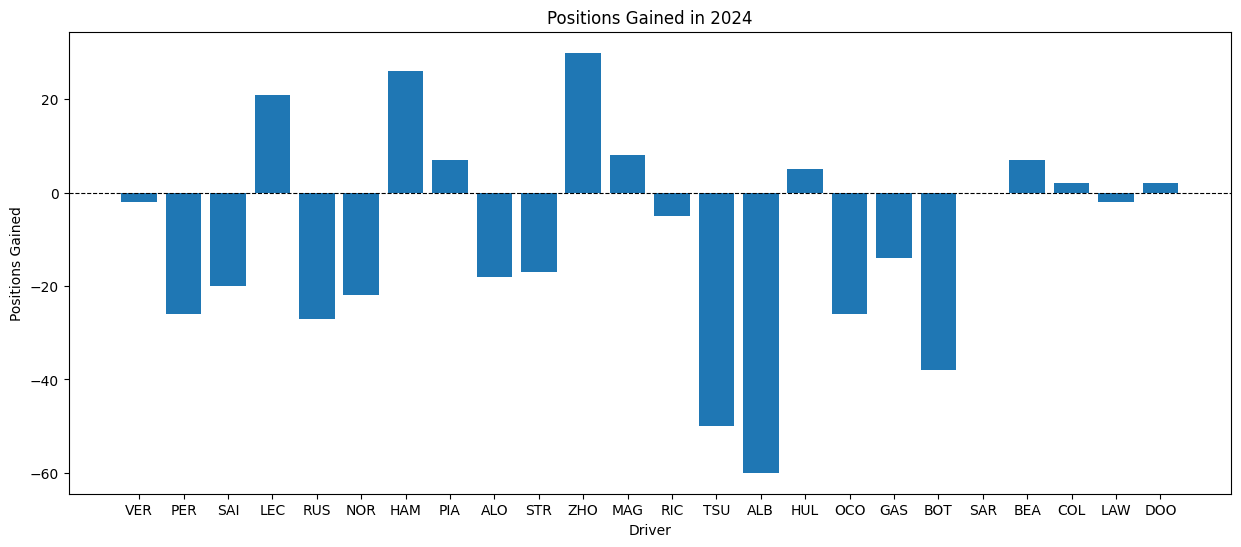

In [4]:
import matplotlib.pyplot as plt

# Total positions gained over the season
# Obviously insanely flawed because it doesn't take into account starting positions and includes anomaly like DNF
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

**Why does this look so negative?**

In terms of starting positions, there is not a number grid position for drivers who start in the pits, and the API returns it as 0. If the driver starts in position 0 then any result, even a 1st place, will be considered a negative result which hugely scew the results.

In order to fix this, we can just manually replace all these 0 values in the starting position with a heuristic calculated starting position. But what if there are multiple starting in the pits? Well there isn't really a way to know, so for now we will just assign this at random.

In [5]:
for race_name, df in race_dataframes.items():
    for index, row in df.iterrows(): 
        starting_pos = row["StartingPosition"]
        if starting_pos == 0:
            df.loc[index, "StartingPosition"] = df["StartingPosition"].max() + 1
    df["PositionsGained"] = df.apply(
        lambda row: int(row["StartingPosition"]) - int(row["RaceResult"]),
        axis=1
    )

print("Results for Bharain:")
print(race_dataframes["Bahrain Grand Prix"])

Results for Bharain:
   DriverCode ConstructorId  StartingPosition  RaceResult  PositionsGained  \
0         VER      red_bull                 1           1                0   
1         PER      red_bull                 5           2                3   
2         SAI       ferrari                 4           3                1   
3         LEC       ferrari                 2           4               -2   
4         RUS      mercedes                 3           5               -2   
5         NOR       mclaren                 7           6                1   
6         HAM      mercedes                 9           7                2   
7         PIA       mclaren                 8           8                0   
8         ALO  aston_martin                 6           9               -3   
9         STR  aston_martin                12          10                2   
10        ZHO        sauber                17          11                6   
11        MAG          haas                

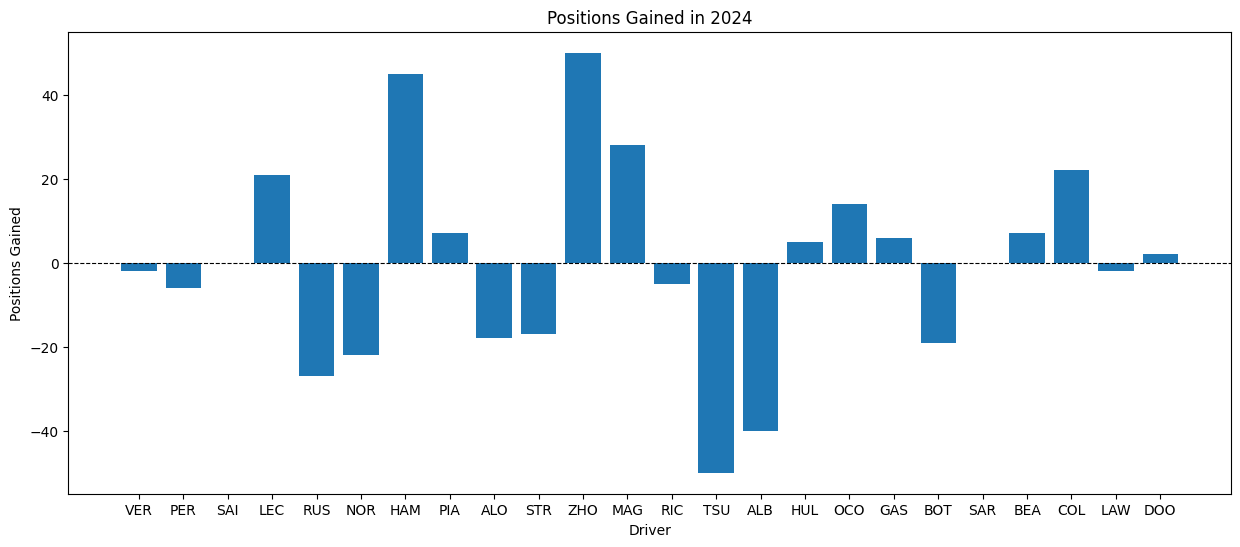

In [6]:
position_gained = {}

for race_name, df in race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

In [7]:
## Combine dataframe with a race ID
i = 1
for race_id, race_df in race_dataframes.items():
    race_df['RaceId'] = i  # Add a race identifier to each row
    i += 1

combined_df = pd.concat(race_dataframes.values(), ignore_index=True)
## In the next itteration of this model I will do feature engineering here to include things like constructor and driver average results to help the model
## but this this benchmark I will only use this.


# Convert categorical columns to numeric
le_driver = LabelEncoder()
le_constructor = LabelEncoder()

combined_df['DriverCode'] = le_driver.fit_transform(combined_df['DriverCode'])
combined_df['ConstructorId'] = le_constructor.fit_transform(combined_df['ConstructorId'])

# Split into features and targets
# Remove the positions gained otherwise thats cheating ofc
features = combined_df.drop(['RaceResult', 'PositionsGained'], axis=1)
targets = combined_df['RaceResult']  

print(features.head(5))
print(features.tail(5))

   DriverCode  ConstructorId  StartingPosition  Q1TimeMS  Q2TimeMs  \
0          22              7                 1     90031     89374   
1          14              7                 5     90221     89932   
2          18              2                 4     89909     89573   
3          10              2                 2     90243     89165   
4          17              5                 3     90350     89922   

   Q2Progress  Q3TimeMs  Q3Progress  RaceId  
0           1     89179           1       1  
1           1     89537           1       1  
2           1     89507           1       1  
3           1     89407           1       1  
4           1     89485           1       1  
     DriverCode  ConstructorId  StartingPosition  Q1TimeMS  Q2TimeMs  \
474          11              3                14     83632     83877   
475           9              6                12     83733     83472   
476           3              8                 9     83481     83341   
477           4

### Test train split ###
Given how important recent performance is on the races, doing the test train split on a race ofrecasting model is different to standard methods.
Again since this is just a V1 baseline of the model, I will use a simple test train split using a cut, but in the future itterations I will experiment with the impact of rolling windows

In [8]:
race_test_split = combined_df["RaceId"].max() - 4

test_split_mask = features["RaceId"] <= race_test_split

features_train = features[test_split_mask]
features_test = features[~test_split_mask]

targets_train = targets[test_split_mask]
targets_test = targets[~test_split_mask]

print(targets_test.tail(5))

474    16
475    17
476    18
477    19
478    20
Name: RaceResult, dtype: int64


##### Model Choices ####

To improve on the previous itteration, this model will use a probabilistic method with int optimisation to ensure each driver has a unique finishing position in the race result. It's expected that while this will reduce the accuracy of the model to some extent this will improve the overall usefulness of the model, and is therefore an essential step.

In [9]:
classifier = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True)

classifier.fit(features_train, targets_train)

RandomForestClassifier(oob_score=True, random_state=0)

In [33]:
probabilities = classifier.predict_proba(features_test)

from scipy.optimize import linear_sum_assignment
import numpy as np

# Split the probabilities array into 4 equal parts (one for each race)
num_races = 4
drivers_per_race = 20

# Validate that the shape aligns with the expected structure
if probabilities.shape[0] % num_races != 0:
    raise ValueError("The number of rows in probabilities must be divisible by the number of races.")

# Split the array
race_probabilities = np.split(probabilities, num_races)

targets_predict = []

for i, race_probs in enumerate(race_probabilities):
    # For each race, we can then use the probabilities to assign their position.

    # Assume probabilities is a matrix where rows are drivers and columns are positions
    cost_matrix = 1 - race_probs
    _, targets_predict_race = linear_sum_assignment(cost_matrix)
    targets_predict_race = [int(x + 1) for x in targets_predict_race]
    targets_predict.extend(targets_predict_race)
print(list(zip(targets_predict,targets_test)))

[(14, 1), (1, 2), (18, 3), (19, 4), (4, 5), (3, 6), (2, 7), (5, 8), (6, 9), (20, 10), (10, 11), (17, 12), (16, 13), (8, 14), (15, 15), (13, 16), (12, 17), (9, 18), (7, 19), (11, 20), (4, 1), (9, 2), (2, 3), (1, 4), (3, 5), (11, 6), (6, 7), (10, 8), (5, 9), (13, 10), (20, 11), (8, 12), (15, 13), (12, 14), (14, 15), (19, 16), (18, 17), (16, 18), (17, 19), (7, 20), (6, 1), (1, 2), (4, 3), (19, 4), (15, 5), (7, 6), (2, 7), (18, 8), (17, 9), (3, 10), (14, 11), (5, 12), (10, 13), (20, 14), (16, 15), (9, 16), (8, 17), (11, 18), (12, 19), (13, 20), (3, 1), (4, 2), (14, 3), (18, 4), (5, 5), (6, 6), (1, 7), (7, 8), (19, 9), (2, 10), (16, 11), (20, 12), (15, 13), (11, 14), (17, 15), (10, 16), (13, 17), (9, 18), (12, 19), (8, 20)]


Accuracy: 3.75%
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.25      0.25      0.25         4
           6       0.25      0.25      0.25         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.25      0.25      0.25         4
          16       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         4
          1

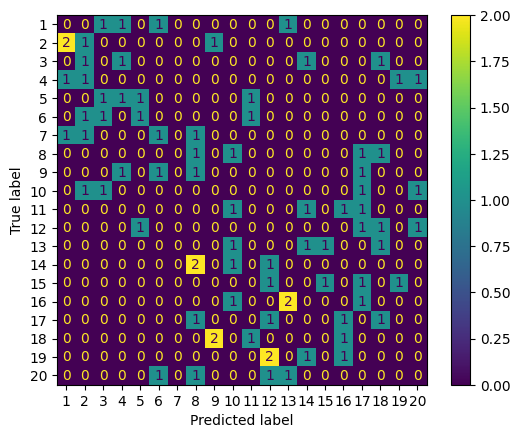

In [24]:


from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

accuracy = accuracy_score(targets_test, targets_predict)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(targets_test, targets_predict))

ConfusionMatrixDisplay.from_estimator(classifier, features_test, targets_test)

#### Results ####

----

##### Model #####

So far just the model has been changed, and we have only evaluated the performance on the very last race. This will be changed after additional parameters are added to the model so we can compare more fairly with the previous model which predicted the results for the last 4 races.

The model actually has a slighly lower average score than the v1 model. This is a mostly negligible amount, but we can attribute this to enforcing a single driver to each position.

#### Average distance from true result ####

In [26]:
import numpy as np
distances = np.abs(targets_test - targets_predict)
average_distance = np.mean(distances)
print(f"Average Distance from True Labels: {average_distance:.2f}")

Average Distance from True Labels: 5.30


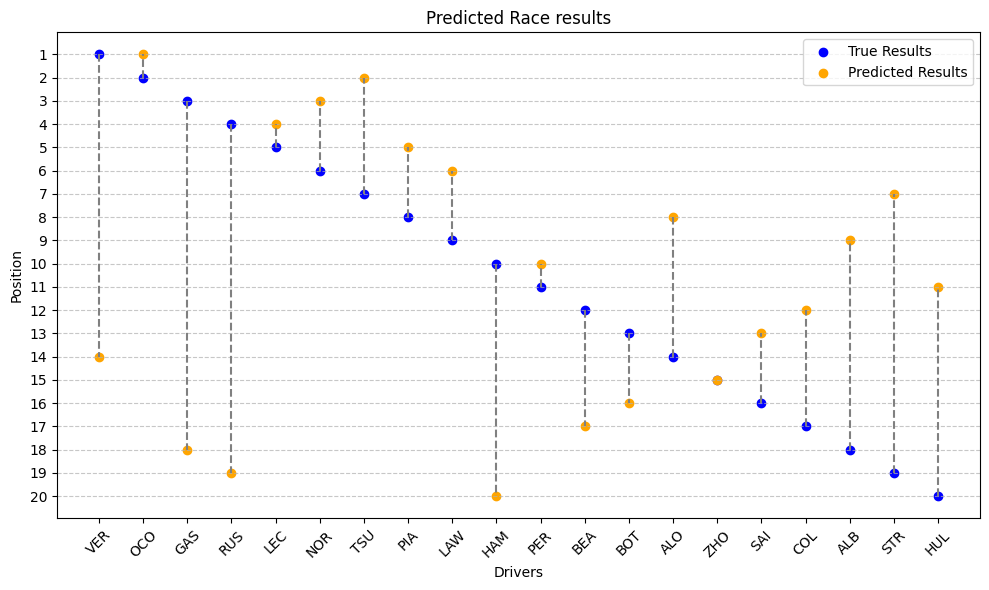

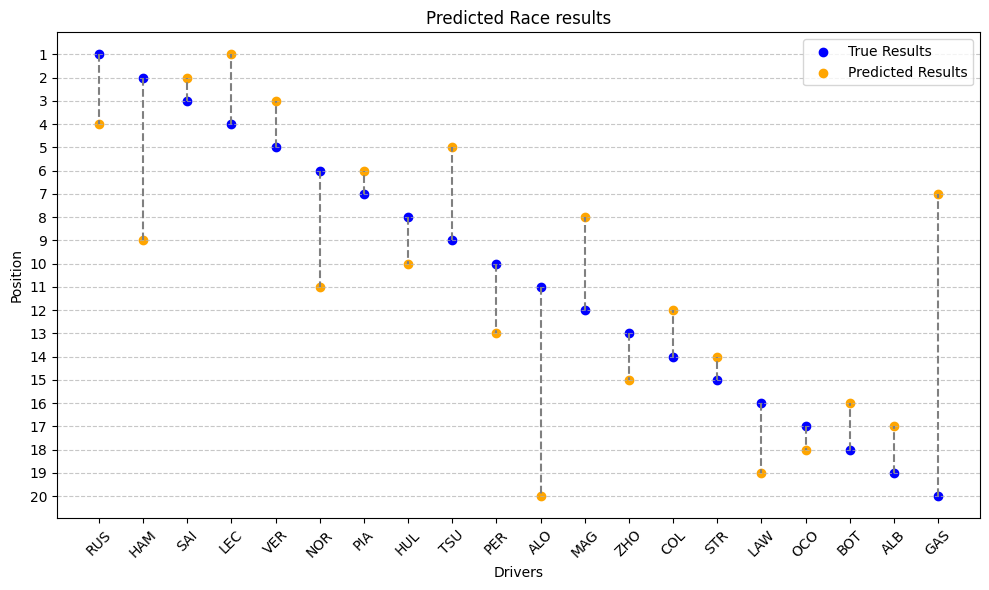

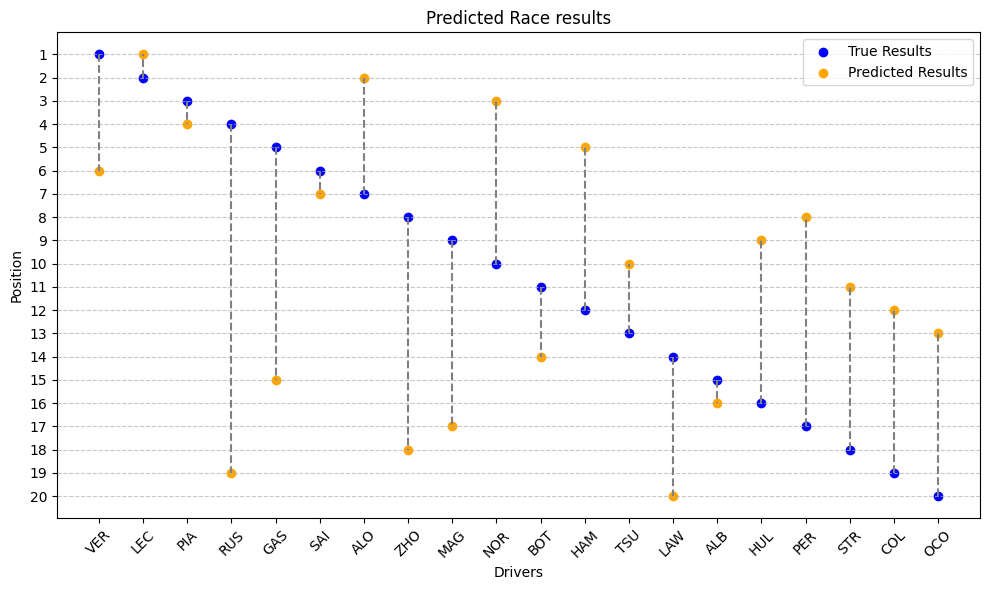

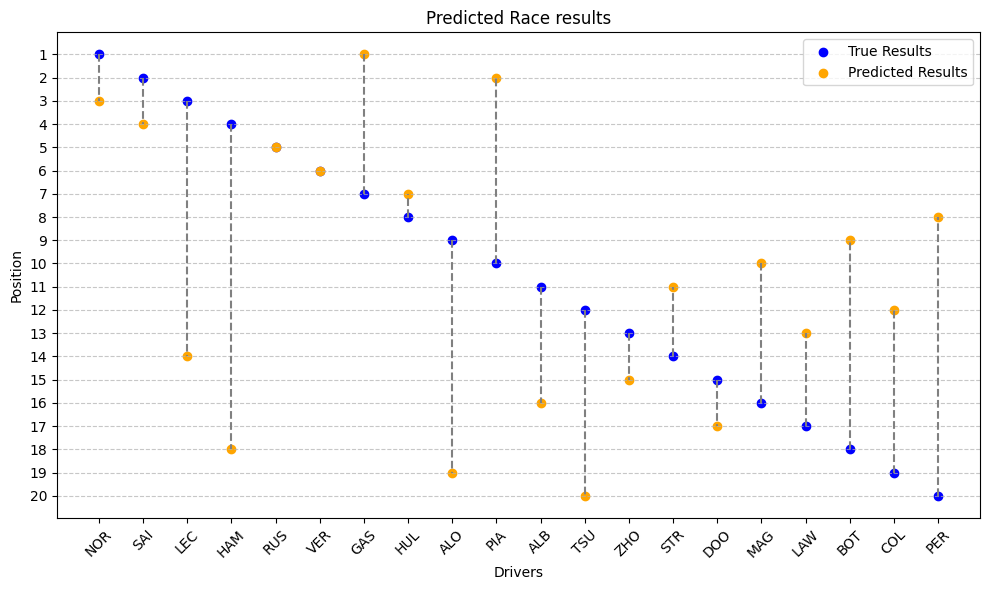

In [34]:
import matplotlib.pyplot as plt

labeled_results = le_driver.inverse_transform(combined_df["DriverCode"])[-80:]
for i in range(4):
    true_results = targets_test[i*20:(i+1)*20]
    driver_labels = labeled_results[i*20:(i+1)*20]
    predicted_results = targets_predict[i*20:(i+1)*20]

    plt.figure(figsize=(10, 6))

    drivers = range(len(true_results))
    plt.scatter(drivers, true_results, label='True Results', color='blue')
    plt.scatter(drivers, predicted_results, label='Predicted Results', color='orange')

    for j in drivers:
        plt.plot([j, j], [true_results.iloc[j], predicted_results[j]], color='gray', linestyle='--')

    plt.xlabel('Drivers')
    plt.ylabel('Position')
    plt.title('Predicted Race results')
    plt.xticks(drivers, driver_labels, rotation=45)
    plt.yticks(np.arange(1, 21, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


The first thing noticable from this is the issue with the classifier not putting exactly one driver into each position.

Additionally there are some drivers who race very irregularly, and for those we have far less data for the model to use. This is a flaw in the data, and there is nothing we can do about this, since driver turnover is inevitable for a multitude of reasons.

As well as this, the model is black box. We can't see why the model suspects some drivers perform far worse than others. In fact there is very little we will ever be able to do about this. The data is inherintly very dirty and unpredictable, otherwise this activity would be no fun :)

Lets see how we can improve things in v2 